In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import func_plot as fp
import seaborn as sns
import nibabel as nib
from scipy.stats import norm
atlas = nib.load('./BD-SCZ/Schaefer2018_400Parcels_7Networks_order.dlabel.nii').get_fdata()[0]
atlas.shape

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(64984,)

# Gradients Parcelwise PLS 10 LV

In [3]:
"""
Partial Least Squares (PLS) pipeline for cortical gradient–behavior relationships.

Now fits multiple LVs (components) to allow later permutation/cross-validation
to determine how many are statistically significant.
"""

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

# ------------------------
# Define cortical gradients
# ------------------------
grad_files = ['./g1_aligned_cog.csv', './g2_aligned_cog.csv', './g3_aligned_cog.csv']
grad_names = ['G1', 'G2', 'G3']

# ------------------------
# Define variable groups
# ------------------------
group_definitions = {
    'Attention_WorkingMemory': ['Digit_span_forward', 'Digit_span_backward',
                                'Digit_span_sequencing', 'Letter_number_sequencing'],
    'VerbalLearning_Memory': ['Long_free_recall', 'Short_free_recall', 'Free_recall_correct'],
    'Reasoning_ProblemSolving': ['Matrix_Reasoning'],
    'Verbal_Comprehension': ['Vocabulary']
}

# Clinical + demographic variables to include
other_vars = ['diagnosis', 'SAPSDisorganization', 'Amotivation', 'DimEx',
              'SAPSPositiveSymptoms', 'hamilton_21', 'YMRS']

# Covariates to regress out from brain features
covariate_cols = ['age', 'gender']

# ------------------------
# Helper functions
# ------------------------
def ensure_numeric_encoding(df, col):
    """Ensure categorical columns (e.g., gender) are numeric."""
    if not np.issubdtype(df[col].dtype, np.number):
        mapping = {k: i for i, k in enumerate(df[col].unique())}
        print(f"Auto-mapped '{col}': {mapping}")
        df[col] = df[col].map(mapping)
    return df


def regress_out(X, covariates):
    """Regress out confounding variables (e.g., age, gender) from each column of X."""
    X_resid = np.zeros_like(X)
    for j in range(X.shape[1]):
        model = LinearRegression().fit(covariates, X[:, j])
        X_resid[:, j] = X[:, j] - model.predict(covariates)
    return X_resid


# ------------------------
# Main analysis
# ------------------------
results = {}
n_components = 10  # number of LVs to fit (can adjust later)

for grad_file, grad_name in zip(grad_files, grad_names):
    print(f"\n--- Processing {grad_name} ---")

    # Load gradient file
    df = pd.read_csv(grad_file)

    # Keep only patients with diagnosis 2 (bipolar) and 3 (schizophrenia)
    patient_df = df[df['diagnosis'].isin([2, 3])].copy()

    # Ensure categorical vars are numeric
    for col in ['gender', 'diagnosis']:
        patient_df = ensure_numeric_encoding(patient_df, col)

    # Define parcel columns (assuming node_1 ... node_400)
    parcel_cols = [f'node_{i+1}' for i in range(400)]
    assert all(col in patient_df.columns for col in parcel_cols), \
        f"Missing parcel columns in {grad_name}"

    X = patient_df[parcel_cols].values

    # ------------------------
    # Create grouped cognitive domains
    # ------------------------
    for group_name, var_list in group_definitions.items():
        # Z-score each cognitive variable before averaging
        zscored = patient_df[var_list].apply(lambda x: (x - x.mean()) / x.std(), axis=0)
        domain_score = zscored.mean(axis=1)
        # Invert so higher = worse
        patient_df[group_name] = -domain_score

    # Combine behavioral + clinical variables (Y)
    Y_cols = other_vars + list(group_definitions.keys())
    Y = patient_df[Y_cols].values

    # ------------------------
    # Remove missing subjects
    # ------------------------
    nan_mask = ~np.isnan(X).any(axis=1) & ~np.isnan(Y).any(axis=1)
    X_valid = X[nan_mask]
    Y_valid = Y[nan_mask]
    patient_df_valid = patient_df.loc[nan_mask].copy()

    # ------------------------
    # Regress out age and gender from X
    # ------------------------
    covars = patient_df_valid[covariate_cols].values
    X_resid = regress_out(X_valid, covars)

    # ------------------------
    # Standardize (z-score) both X and Y
    # ------------------------
    X_std = StandardScaler().fit_transform(X_resid)
    Y_std = StandardScaler().fit_transform(Y_valid)

    # ------------------------
    # Fit Partial Least Squares (multiple LVs)
    # ------------------------
    pls = PLSRegression(n_components=n_components)
    pls.fit(X_std, Y_std)

    # Extract scores and weights for all LVs
    X_scores = pls.x_scores_
    Y_scores = pls.y_scores_
    X_weights = pls.x_weights_
    Y_weights = pls.y_weights_

    # ------------------------
    # Compute variance explained
    # ------------------------
    total_var_X = np.var(X_std, axis=0).sum()
    total_var_Y = np.var(Y_std, axis=0).sum()
    var_X_expl = []
    var_Y_expl = []
    shared_var = []

    for lv in range(n_components):
        T = X_scores[:, lv:lv+1]
        U = Y_scores[:, lv:lv+1]
        P = pls.x_loadings_[:, lv:lv+1]
        Q = pls.y_loadings_[:, lv:lv+1]

        X_pred = T @ P.T
        Y_pred = T @ Q.T

        var_X_expl.append(np.var(X_pred, axis=0).sum() / total_var_X)
        var_Y_expl.append(np.var(Y_pred, axis=0).sum() / total_var_Y)
        shared_var.append(np.corrcoef(T[:, 0], U[:, 0])[0, 1] ** 2)

    # ------------------------
    # Save results
    # ------------------------
    results[grad_name] = {
        'X_scores': X_scores,
        'Y_scores': Y_scores,
        'X_weights': X_weights,
        'Y_weights': Y_weights,
        'X_std': X_std,
        'Y_std': Y_std,
        'var_X_expl': var_X_expl,
        'var_Y_expl': var_Y_expl,
        'shared_var': shared_var,
        'Y_cols': Y_cols
    }

    # ------------------------
    # Print variance summary
    # ------------------------
    print(f"\n{grad_name} variance explained per LV:")
    print(f"{'LV':>3} | {'X Var (%)':>10} | {'Y Var (%)':>10} | {'Shared Var (%)':>14}")
    print("-" * 45)
    for lv in range(n_components):
        print(f"{lv+1:>3} | {var_X_expl[lv]*100:10.2f} | "
              f"{var_Y_expl[lv]*100:10.2f} | {shared_var[lv]*100:14.2f}")

# ------------------------
# End of pipeline
# ------------------------
print("\nAll gradients processed. Results with all LVs stored in `results` dict.")



--- Processing G1 ---

G1 variance explained per LV:
 LV |  X Var (%) |  Y Var (%) | Shared Var (%)
---------------------------------------------
  1 |       8.62 |      10.12 |          34.05
  2 |       5.23 |       8.79 |          43.25
  3 |       5.17 |       6.86 |          51.02
  4 |       3.65 |       9.32 |          53.24
  5 |       2.83 |       7.63 |          47.06
  6 |       3.52 |       5.73 |          53.37
  7 |       3.35 |       4.05 |          42.20
  8 |       4.13 |       2.90 |          47.88
  9 |       2.14 |       4.06 |          68.65
 10 |       2.50 |       3.46 |          61.66

--- Processing G2 ---

G2 variance explained per LV:
 LV |  X Var (%) |  Y Var (%) | Shared Var (%)
---------------------------------------------
  1 |       5.01 |      14.25 |          47.63
  2 |       4.48 |       8.82 |          45.20
  3 |       5.26 |       6.05 |          37.31
  4 |       6.11 |       6.03 |          43.64
  5 |       5.10 |       5.21 |          56.59
 

## Permutation testing

In [4]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression

# -------------------------------
# Permutation testing parameters
# -------------------------------
n_permutations = 10000   # number of permutations (e.g., 10000 for robust p-values)
n_components = 10        # number of LVs to test (should match what you fitted)
results_perm = {}        # store permutation results

# -------------------------------
# Loop over gradients
# -------------------------------
for grad_name, res in results.items():
    print(f"\nPermutation testing for {grad_name}...")

    # Retrieve standardized X and Y
    X = res['X_std']  # standardized brain data
    Y = res['Y_std']  # standardized behavioral data

    # Fit original PLS with all components
    pls = PLSRegression(n_components=n_components)
    pls.fit(X, Y)

    # Compute observed singular (covariance) values per LV
    obs_singular_values = np.zeros(n_components)
    for lv in range(n_components):
        X_scores = pls.x_scores_[:, lv]
        Y_scores = pls.y_scores_[:, lv]
        obs_singular_values[lv] = np.cov(X_scores, Y_scores, bias=True)[0, 1]

    # -----------------------
    # Run permutations
    # -----------------------
    perm_singular_values = np.zeros((n_permutations, n_components))

    for i in range(n_permutations):
        # Shuffle rows of X (breaks brain–behavior link)
        X_perm = X[np.random.permutation(X.shape[0]), :]
        pls_perm = PLSRegression(n_components=n_components)
        pls_perm.fit(X_perm, Y)

        for lv in range(n_components):
            X_scores_perm = pls_perm.x_scores_[:, lv]
            Y_scores_perm = pls_perm.y_scores_[:, lv]
            perm_singular_values[i, lv] = np.cov(X_scores_perm, Y_scores_perm, bias=True)[0, 1]

        if (i + 1) % 1000 == 0:
            print(f"  {i+1}/{n_permutations} permutations complete...")

    # -----------------------
    # Compute permutation p-values per LV
    # -----------------------
    p_values = np.mean(perm_singular_values >= obs_singular_values[None, :], axis=0)

    # -----------------------
    # Store results
    # -----------------------
    results_perm[grad_name] = {
        'obs_singular_values': obs_singular_values,
        'perm_singular_values': perm_singular_values,
        'p_values': p_values
    }

    # -----------------------
    # Print summary
    # -----------------------
    print(f"\n{grad_name} permutation-based significance results:")
    print(f"{'LV':>3} | {'Observed Cov':>14} | {'p-value':>8}")
    print("-" * 33)
    for lv in range(n_components):
        sig_marker = "*" if p_values[lv] < 0.05 else " "
        print(f"{lv+1:>3} | {obs_singular_values[lv]:14.5f} | {p_values[lv]:8.4f} {sig_marker}")

print("\nAll gradients tested. Results stored in `results_perm` dict.")



Permutation testing for G1...


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


  1000/10000 permutations complete...


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


  2000/10000 permutations complete...


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


  3000/10000 permutations complete...
  4000/10000 permutations complete...


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


  5000/10000 permutations complete...


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


  6000/10000 permutations complete...


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


  7000/10000 permutations complete...
  8000/10000 permutations complete...
  9000/10000 permutations complete...
  10000/10000 permutations complete...

G1 permutation-based significance results:
 LV |   Observed Cov |  p-value
---------------------------------
  1 |       24.20843 |   0.0878  
  2 |       12.97890 |   0.7533  
  3 |       14.74444 |   0.4518  
  4 |       10.74382 |   0.6612  
  5 |        8.11170 |   0.9095  
  6 |       10.43547 |   0.4682  
  7 |        9.40281 |   0.4973  
  8 |       12.84675 |   0.0334 *
  9 |        6.67108 |   0.8059  
 10 |        7.67013 |   0.3574  

Permutation testing for G2...


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


  1000/10000 permutations complete...
  2000/10000 permutations complete...
  3000/10000 permutations complete...


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


  4000/10000 permutations complete...
  5000/10000 permutations complete...
  6000/10000 permutations complete...
  7000/10000 permutations complete...


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


  8000/10000 permutations complete...


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


  9000/10000 permutations complete...
  10000/10000 permutations complete...

G2 permutation-based significance results:
 LV |   Observed Cov |  p-value
---------------------------------
  1 |       13.47448 |   0.6198  
  2 |       12.23199 |   0.7719  
  3 |       14.32808 |   0.3677  
  4 |       13.50054 |   0.2650  
  5 |       16.79836 |   0.0222 *
  6 |        5.88380 |   0.9943  
  7 |        9.53988 |   0.4653  
  8 |       10.14673 |   0.1952  
  9 |        7.19529 |   0.6453  
 10 |        5.51033 |   0.9484  

Permutation testing for G3...


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


  1000/10000 permutations complete...
  2000/10000 permutations complete...
  3000/10000 permutations complete...


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


  4000/10000 permutations complete...
  5000/10000 permutations complete...
  6000/10000 permutations complete...
  7000/10000 permutations complete...
  8000/10000 permutations complete...
  9000/10000 permutations complete...


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


  10000/10000 permutations complete...

G3 permutation-based significance results:
 LV |   Observed Cov |  p-value
---------------------------------
  1 |       12.11364 |   0.6912  
  2 |       10.53877 |   0.9292  
  3 |       21.50912 |   0.0321 *
  4 |       12.19279 |   0.4202  
  5 |       12.55647 |   0.1572  
  6 |        7.22780 |   0.8609  
  7 |       11.43423 |   0.0361 *
  8 |        7.52425 |   0.4976  
  9 |        6.87419 |   0.5545  
 10 |        7.52181 |   0.2165  

All gradients tested. Results stored in `results_perm` dict.


## Permutation visualization

--> Red line far to the right of the histogram:
Observed covariance is larger than almost all permuted values → LV is significant (small p-value).

--> Red line overlapping the histogram:
Observed covariance is similar to what you’d see by chance → LV is not significant (p-value near 0.5 or higher).

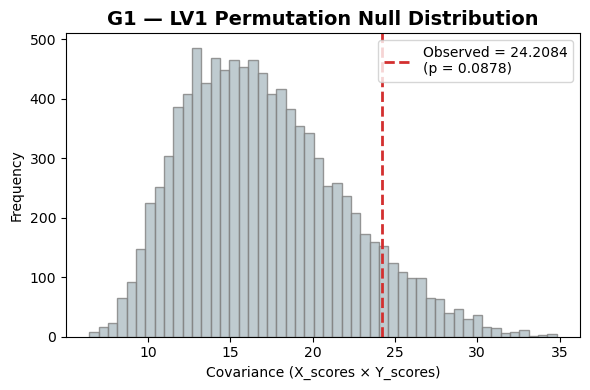

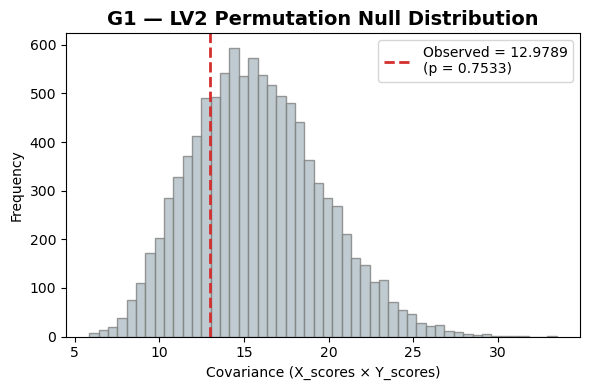

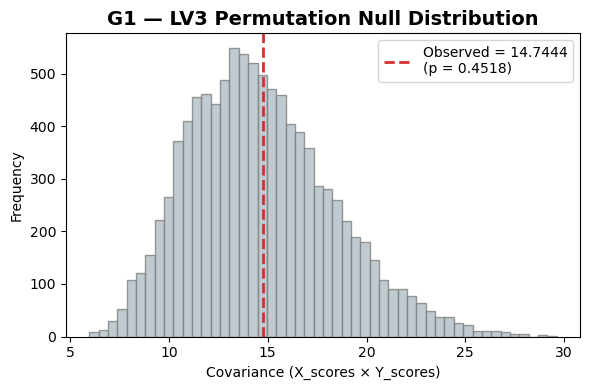

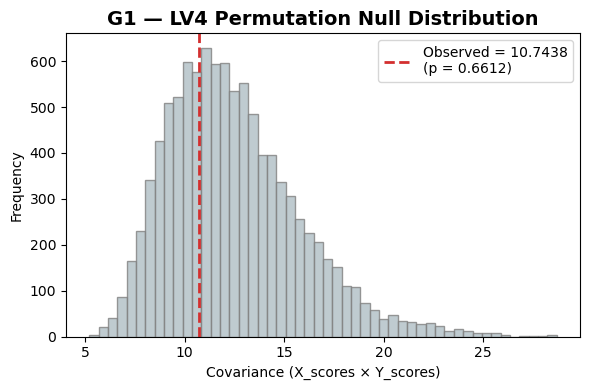

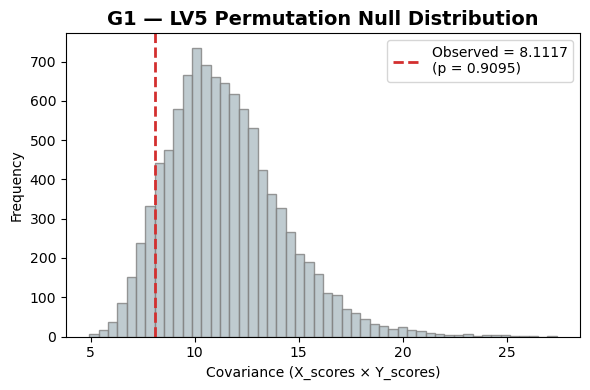

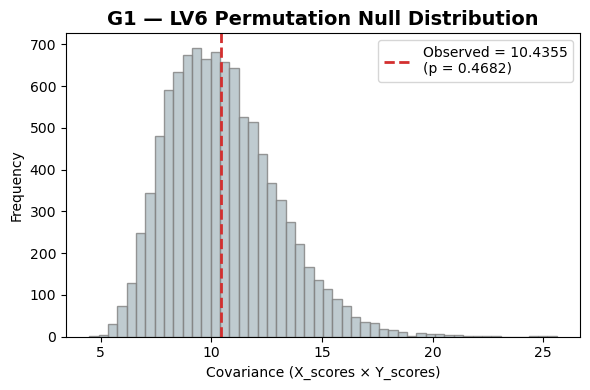

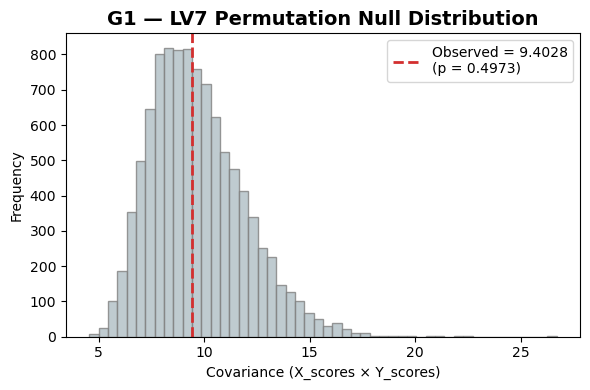

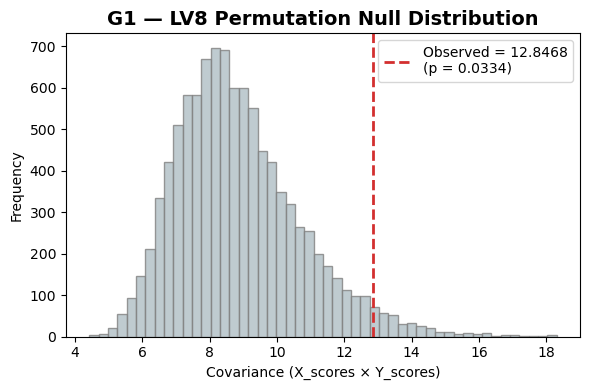

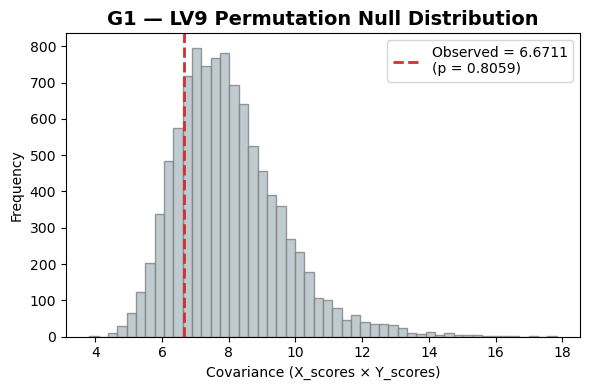

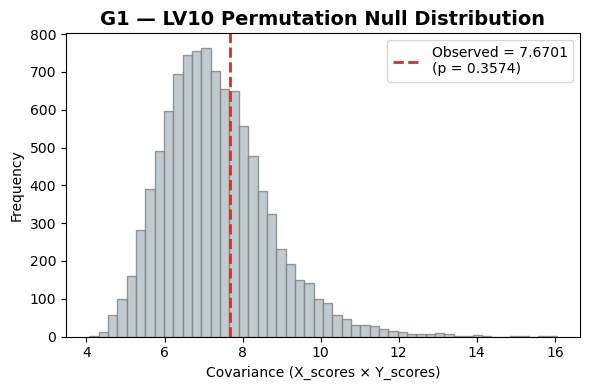

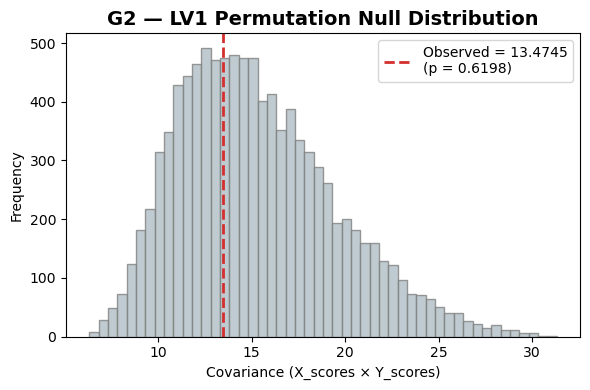

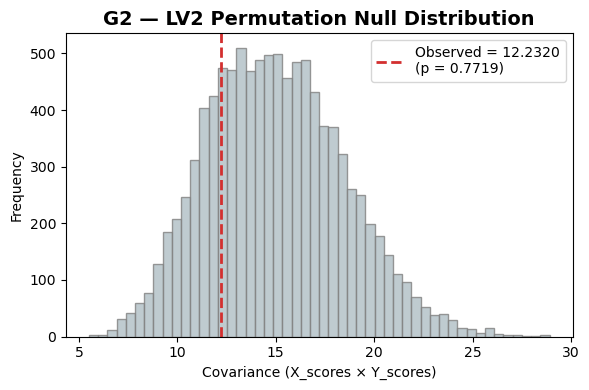

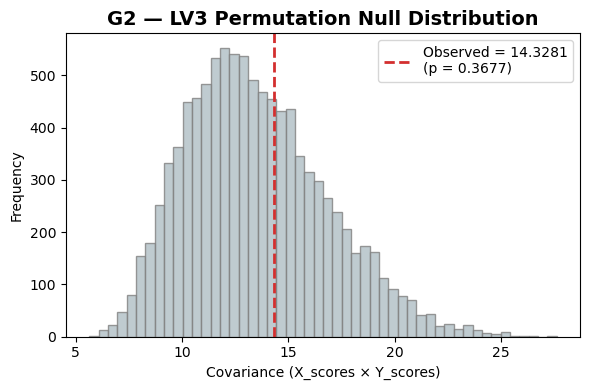

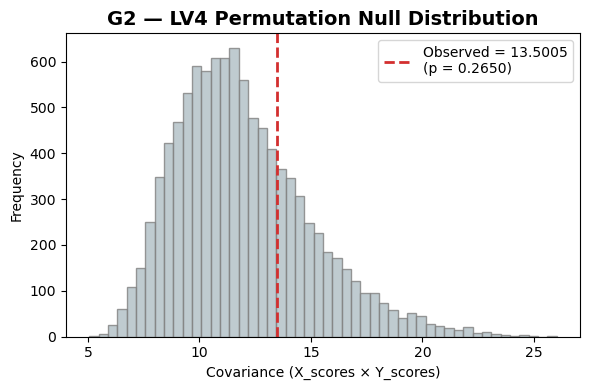

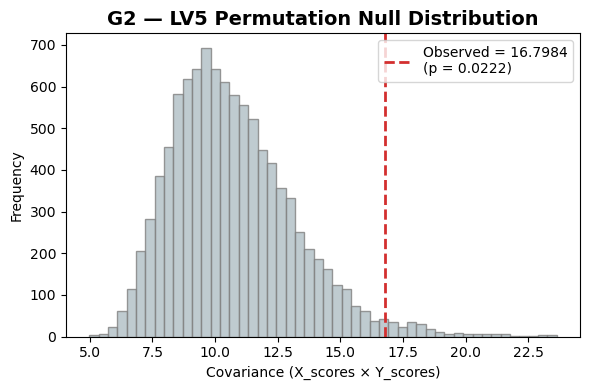

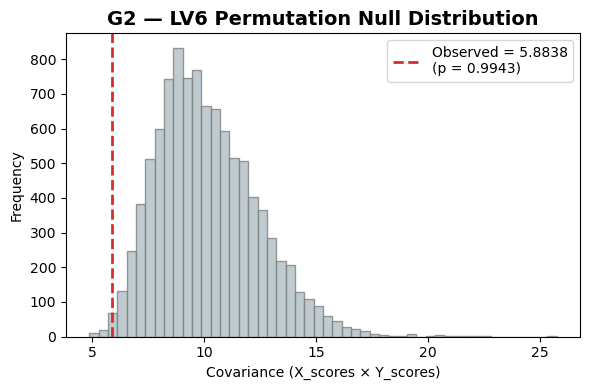

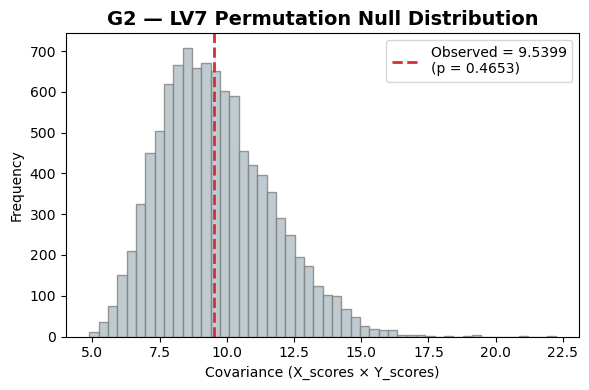

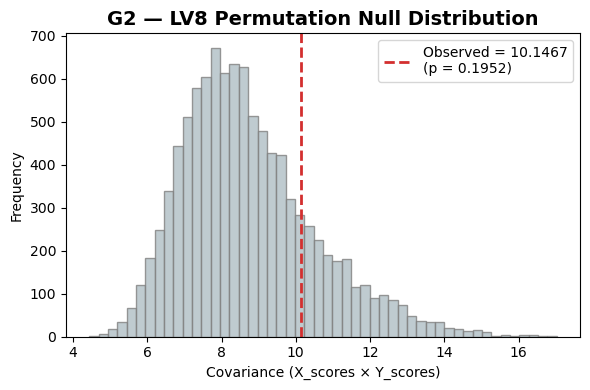

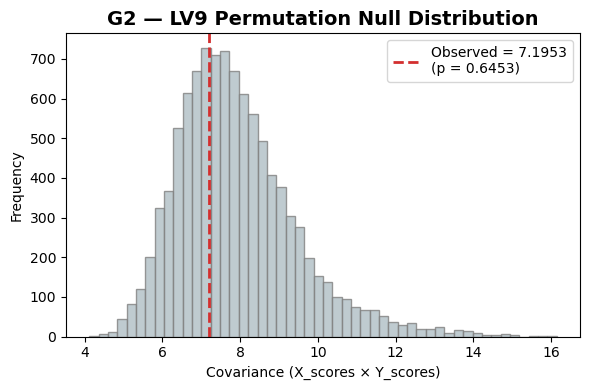

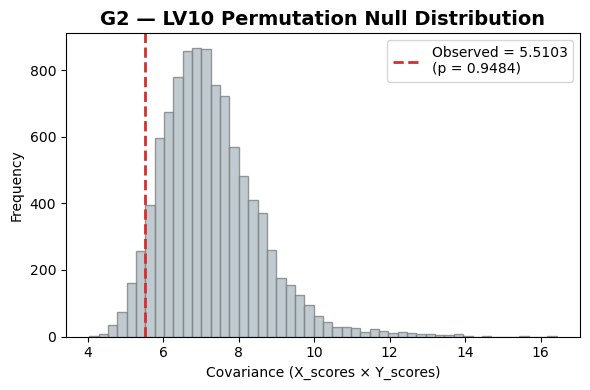

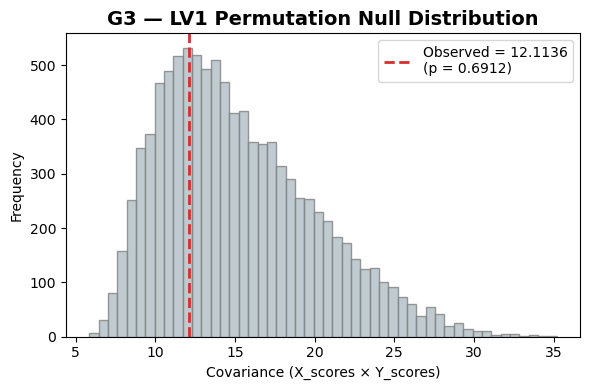

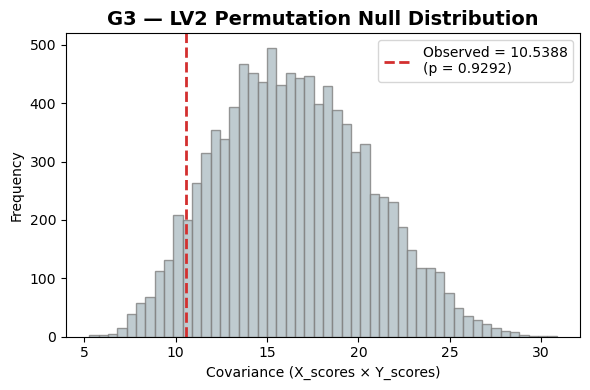

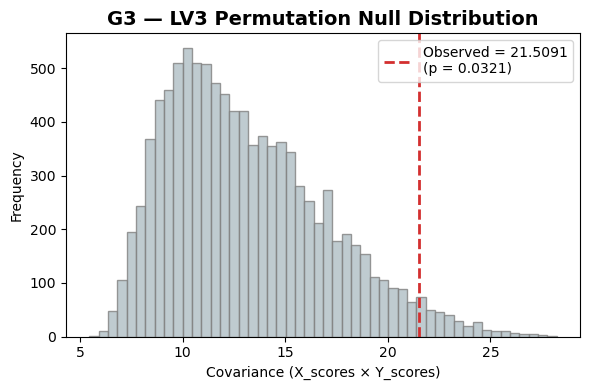

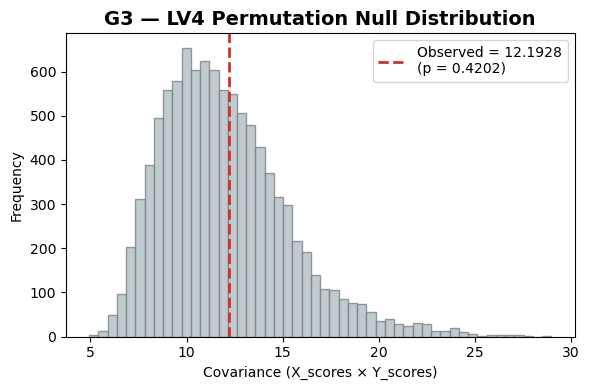

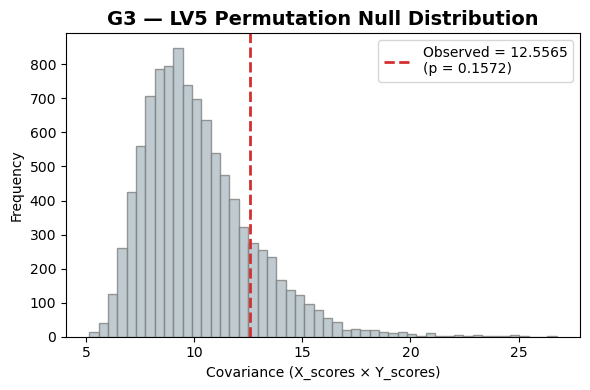

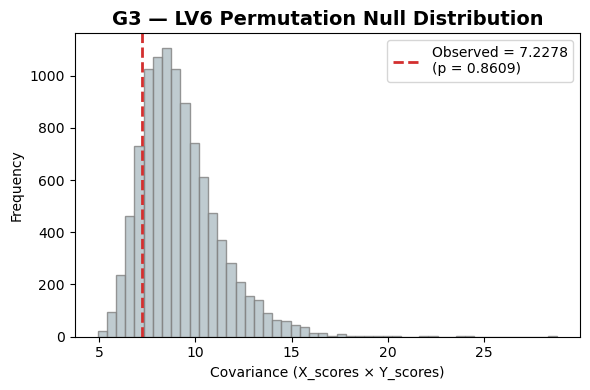

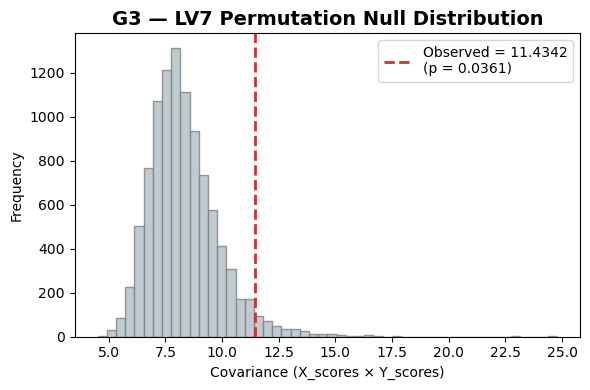

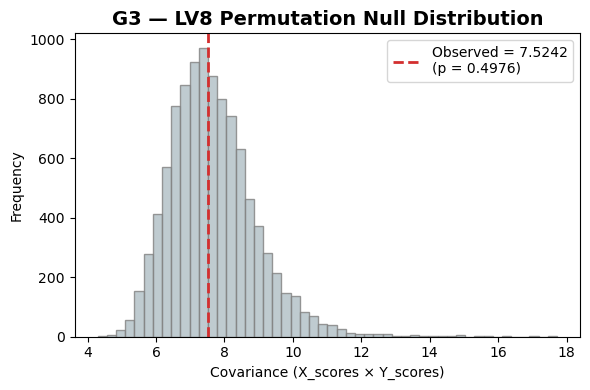

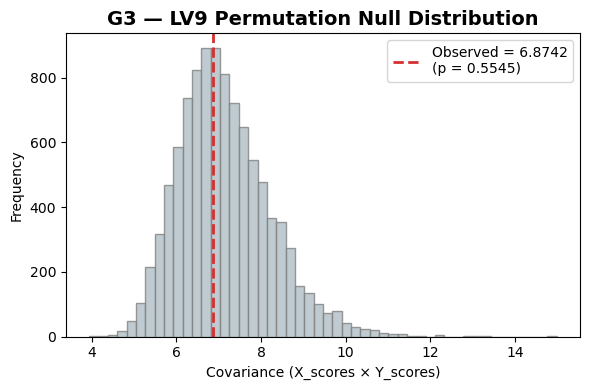

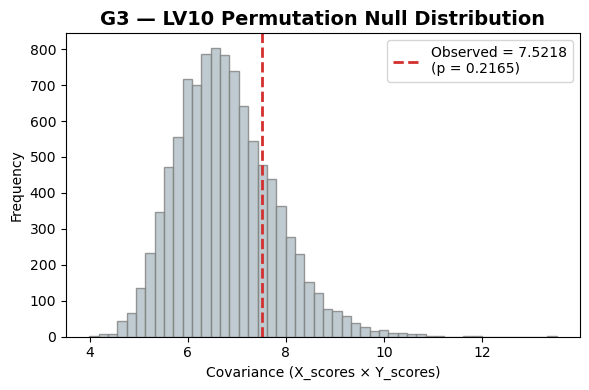

✅ Permutation histograms saved to 'new_figures/' and displayed.


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Create folder for output figures
os.makedirs("new_figures", exist_ok=True)

# Plot permutation null distributions per LV and gradient
for grad_name, res_perm in results_perm.items():
    obs_vals = res_perm['obs_singular_values']
    perm_vals = res_perm['perm_singular_values']
    p_vals = res_perm['p_values']
    n_components = len(obs_vals)

    for lv in range(n_components):
        plt.figure(figsize=(6, 4))
        plt.hist(perm_vals[:, lv], bins=50, color="#B0BEC5", edgecolor="gray", alpha=0.8)
        plt.axvline(obs_vals[lv], color="#D32F2F", linestyle="--", linewidth=2,
                    label=f"Observed = {obs_vals[lv]:.4f}\n(p = {p_vals[lv]:.4f})")
        plt.title(f"{grad_name} — LV{lv+1} Permutation Null Distribution", fontsize=14, fontweight="bold")
        plt.xlabel("Covariance (X_scores × Y_scores)")
        plt.ylabel("Frequency")
        plt.legend()
        plt.tight_layout()
        # Save figure
        plt.savefig(f"new_figures/{grad_name}_LV{lv+1}_permutation_hist.png", dpi=300)
        # Show figure
        plt.show()
        # Optionally close to free memory (can skip if you want it open)
        plt.close()

print("✅ Permutation histograms saved to 'new_figures/' and displayed.")


## Cross-validation

In [6]:
from sklearn.model_selection import KFold
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr
import numpy as np

# -------------------------------
# Cross-validation parameters
# -------------------------------
n_splits = 5        # 5-fold CV (common choice)
n_components = 10   # match your main PLS fit
results_cv = {}

for grad_name, res in results.items():
    print(f"\nCross-validating PLS model for {grad_name}...")

    X = res['X_std']
    Y = res['Y_std']
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    corr_list = np.zeros((n_splits, n_components))

    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X)):
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]

        pls = PLSRegression(n_components=n_components)
        pls.fit(X_train, Y_train)

        # Compute test scores
        X_test_scores = pls.transform(X_test)
        Y_pred = pls.predict(X_test)

        # Compute correlation between predicted and actual Y-scores per LV
        for lv in range(n_components):
            r, _ = pearsonr(X_test_scores[:, lv], Y_test @ pls.y_weights_[:, lv])
            corr_list[fold_idx, lv] = r

    # Average correlations across folds
    mean_corr = np.nanmean(corr_list, axis=0)
    std_corr = np.nanstd(corr_list, axis=0)

    results_cv[grad_name] = {'mean_corr': mean_corr, 'std_corr': std_corr}

    # Print summary
    print(f"{'LV':>3} | {'Mean Corr':>10} | {'SD':>8}")
    print("-" * 28)
    for lv in range(n_components):
        sig_marker = "*" if mean_corr[lv] > 0.3 else " "
        print(f"{lv+1:>3} | {mean_corr[lv]:10.3f} | {std_corr[lv]:8.3f} {sig_marker}")

print("\n✅ Cross-validation results stored in `results_cv`.")



Cross-validating PLS model for G1...
 LV |  Mean Corr |       SD
----------------------------
  1 |      0.156 |    0.215  
  2 |     -0.214 |    0.189  
  3 |      0.025 |    0.158  
  4 |     -0.014 |    0.183  
  5 |     -0.099 |    0.093  
  6 |      0.056 |    0.198  
  7 |      0.064 |    0.136  
  8 |      0.092 |    0.151  
  9 |      0.075 |    0.214  
 10 |     -0.065 |    0.193  

Cross-validating PLS model for G2...
 LV |  Mean Corr |       SD
----------------------------
  1 |      0.060 |    0.166  
  2 |     -0.253 |    0.137  
  3 |     -0.033 |    0.153  
  4 |     -0.102 |    0.224  
  5 |     -0.147 |    0.229  
  6 |     -0.246 |    0.233  
  7 |      0.048 |    0.362  
  8 |     -0.027 |    0.293  
  9 |     -0.178 |    0.460  
 10 |     -0.088 |    0.168  

Cross-validating PLS model for G3...
 LV |  Mean Corr |       SD
----------------------------
  1 |     -0.196 |    0.165  
  2 |      0.027 |    0.114  
  3 |      0.100 |    0.279  
  4 |     -0.049 |    0.2

## Cross validation visualization
- Bar height (mean correlation) --> This is the average correlation between the predicted LV scores from cross-validation and the actual LV scores. It measures how well the LV pattern generalizes to unseen subjects.
Higher → the LV reliably captures brain–behavior covariance across different subsets of the data.
Close to 0 → the LV is not generalizing; it may only fit the training data.

- Error bars (standard deviation across folds) --> Indicates variability of the correlation across cross-validation splits.
Small error bar → LV is stable, consistent across different splits.
Large error bar → LV is unstable; its predictive pattern changes depending on which subjects are in the training set.

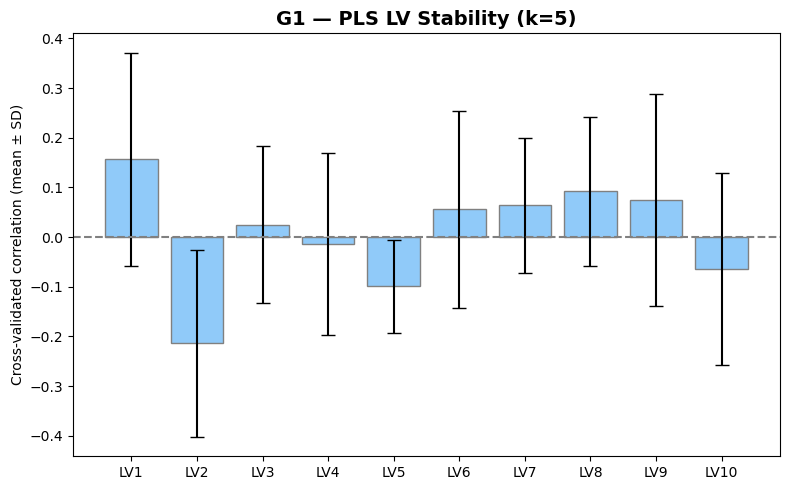

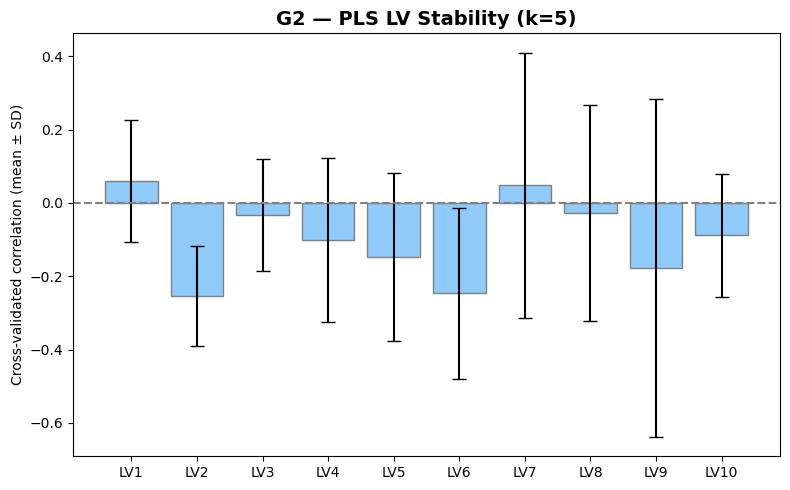

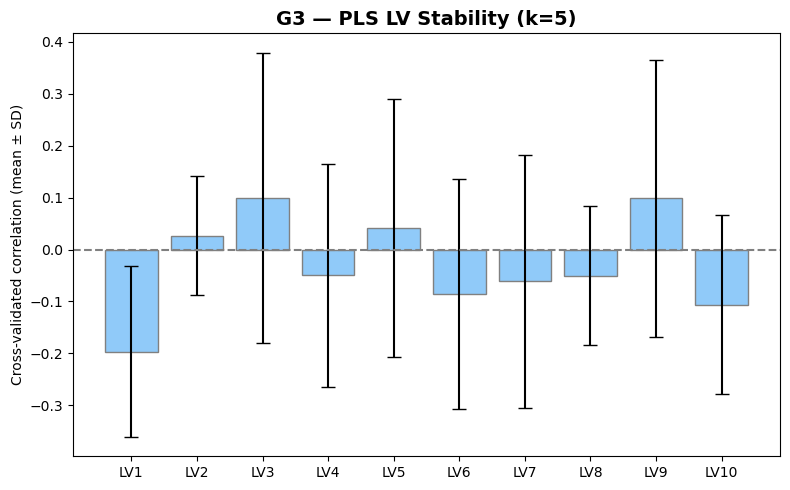

✅ Cross-validation stability plots saved to 'new_figures/' and displayed.


In [7]:
import matplotlib.pyplot as plt
import os

# Ensure output folder exists
os.makedirs("new_figures", exist_ok=True)

for grad_name, res_cv in results_cv.items():
    mean_corr = res_cv['mean_corr']
    std_corr = res_cv['std_corr']
    lv_labels = [f"LV{i+1}" for i in range(len(mean_corr))]

    plt.figure(figsize=(8, 5))
    plt.bar(lv_labels, mean_corr, yerr=std_corr, capsize=5, color="#90CAF9", edgecolor="gray")
    plt.axhline(0, color="gray", linestyle="--")
    plt.ylabel("Cross-validated correlation (mean ± SD)")
    plt.title(f"{grad_name} — PLS LV Stability (k={n_splits})", fontsize=14, fontweight="bold")
    plt.tight_layout()
    
    # Save figure
    plt.savefig(f"new_figures/{grad_name}_CV_stability.png", dpi=300)
    # Show figure interactively
    plt.show()
    # Optional: close to free memory
    plt.close()

print("✅ Cross-validation stability plots saved to 'new_figures/' and displayed.")


# Gradients Parcelwise PLS 3 LV

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

# ------------------------
# Define cortical gradients
# ------------------------
grad_files = ['./g1_aligned_cog.csv', './g2_aligned_cog.csv', './g3_aligned_cog.csv']
grad_names = ['G1', 'G2', 'G3']

# ------------------------
# Define variable groups
# ------------------------
group_definitions = {
    'Attention_WorkingMemory': ['Digit_span_forward', 'Digit_span_backward',
                                'Digit_span_sequencing', 'Letter_number_sequencing'],
    'VerbalLearning_Memory': ['Long_free_recall', 'Short_free_recall', 'Free_recall_correct'],
    'Reasoning_ProblemSolving': ['Matrix_Reasoning'],
    'Verbal_Comprehension': ['Vocabulary']
}

# Clinical + demographic variables
other_vars = ['diagnosis', 'SAPSDisorganization', 'Amotivation', 'DimEx',
              'SAPSPositiveSymptoms', 'hamilton_21', 'YMRS']

# Covariates to regress out from brain features
covariate_cols = ['age', 'gender']

# ------------------------
# Helper functions
# ------------------------
def ensure_numeric_encoding(df, col):
    if not np.issubdtype(df[col].dtype, np.number):
        mapping = {k: i for i, k in enumerate(df[col].unique())}
        print(f"Auto-mapped '{col}': {mapping}")
        df[col] = df[col].map(mapping)
    return df

def regress_out(X, covariates):
    X_resid = np.zeros_like(X)
    for j in range(X.shape[1]):
        model = LinearRegression().fit(covariates, X[:, j])
        X_resid[:, j] = X[:, j] - model.predict(covariates)
    return X_resid

# ------------------------
# Main analysis
# ------------------------
results_3comp = {}

for grad_file, grad_name in zip(grad_files, grad_names):
    print(f"\n--- Processing {grad_name} ---")

    # Load gradient file
    df = pd.read_csv(grad_file)

    # Keep only patients with diagnosis 2 (bipolar) and 3 (schizophrenia)
    patient_df = df[df['diagnosis'].isin([2, 3])].copy()

    # Ensure categorical vars are numeric
    for col in ['gender', 'diagnosis']:
        patient_df = ensure_numeric_encoding(patient_df, col)

    # Define parcel columns
    parcel_cols = [f'node_{i+1}' for i in range(400)]
    assert all(col in patient_df.columns for col in parcel_cols), \
        f"Missing parcel columns in {grad_name}"

    X = patient_df[parcel_cols].values

    # ------------------------
    # Create grouped cognitive domains
    # ------------------------
    for group_name, var_list in group_definitions.items():
        zscored = patient_df[var_list].apply(lambda x: (x - x.mean()) / x.std(), axis=0)
        patient_df[group_name] = -zscored.mean(axis=1)  # invert: higher = worse

    # Combine behavioral + clinical variables (Y)
    Y_cols = other_vars + list(group_definitions.keys())
    Y = patient_df[Y_cols].values

    # Remove any subjects with missing data in X or Y
    valid_mask = ~(np.isnan(X).any(axis=1) | np.isnan(Y).any(axis=1))
    X_valid = X[valid_mask]
    Y_valid = Y[valid_mask]
    patient_df_valid = patient_df.loc[valid_mask].copy()

    # Regress out age and gender from X
    covars = patient_df_valid[covariate_cols].values
    X_resid = regress_out(X_valid, covars)

    # Standardize X and Y
    X_std = StandardScaler().fit_transform(X_resid)
    Y_std = StandardScaler().fit_transform(Y_valid)

    # Fit PLS with 3 components
    n_components = 3
    pls = PLSRegression(n_components=n_components)
    pls.fit(X_std, Y_std)

    # Extract saliences and scores for all LVs
    X_saliences = pls.x_weights_   # shape: (n_voxels, 3)
    Y_saliences = pls.y_weights_   # shape: (n_behav, 3)
    X_scores = pls.x_scores_       # shape: (n_subjects, 3)
    Y_scores = pls.y_scores_       # shape: (n_subjects, 3)

    # Compute behavioral correlations per LV
    behav_corrs = {}
    for lv in range(n_components):
        lv_corrs = {}
        for i, var in enumerate(Y_cols):
            corr, _ = pearsonr(Y_std[:, i], Y_scores[:, lv])
            lv_corrs[var] = corr
        behav_corrs[f"LV{lv+1}"] = lv_corrs

    # Save results
    results_3comp[grad_name] = {
        'X_scores': X_scores,
        'Y_scores': Y_scores,
        'X_saliences': X_saliences,
        'Y_saliences': Y_saliences,
        'behav_corrs': behav_corrs,
        'valid_idx': valid_mask,
        'patient_df': patient_df_valid,
        'X_std': X_std,
        'Y_std': Y_std,
        'n_components': n_components
    }

    # Print summary
    print(f"{grad_name} behavioral correlations:")
    for lv, lv_corrs in behav_corrs.items():
        print(f"  {lv}:")
        for var, corr in lv_corrs.items():
            print(f"    {var:25s}: {corr:6.3f}")

print("\nAll gradients processed. Results stored in `results` dict.")



--- Processing G1 ---
G1 behavioral correlations:
  LV1:
    diagnosis                :  0.792
    SAPSDisorganization      : -0.540
    Amotivation              : -0.626
    DimEx                    : -0.549
    SAPSPositiveSymptoms     : -0.848
    hamilton_21              : -0.251
    YMRS                     : -0.185
    Attention_WorkingMemory  : -0.518
    VerbalLearning_Memory    : -0.520
    Reasoning_ProblemSolving : -0.498
    Verbal_Comprehension     : -0.502
  LV2:
    diagnosis                :  0.449
    SAPSDisorganization      : -0.550
    Amotivation              : -0.612
    DimEx                    : -0.276
    SAPSPositiveSymptoms     : -0.602
    hamilton_21              : -0.364
    YMRS                     : -0.464
    Attention_WorkingMemory  : -0.483
    VerbalLearning_Memory    : -0.389
    Reasoning_ProblemSolving : -0.414
    Verbal_Comprehension     : -0.390
  LV3:
    diagnosis                : -0.394
    SAPSDisorganization      : -0.110
    Amotivation 

## Permutation testing

In [16]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression

# -------------------------------
# Permutation testing parameters
# -------------------------------
n_permutations_3comp = 10000   # number of permutations
n_components_3comp = 3         # number of LVs to test (3-component version)
results_perm_3comp = {}        # store permutation results

# -------------------------------
# Loop over gradients
# -------------------------------
for grad_name_3comp, res_3comp in results_3comp.items():
    print(f"\nPermutation testing for {grad_name_3comp} (3 components)...")

    # Retrieve standardized X and Y
    X_3comp = res_3comp['X_std']  # standardized brain data
    Y_3comp = res_3comp['Y_std']  # standardized behavioral data

    # Fit original PLS with 3 components
    pls_3comp = PLSRegression(n_components=n_components_3comp)
    pls_3comp.fit(X_3comp, Y_3comp)

    # Compute observed singular (covariance) values per LV
    obs_singular_values_3comp = np.zeros(n_components_3comp)
    for lv_3comp in range(n_components_3comp):
        X_scores_3comp = pls_3comp.x_scores_[:, lv_3comp]
        Y_scores_3comp = pls_3comp.y_scores_[:, lv_3comp]
        obs_singular_values_3comp[lv_3comp] = np.cov(X_scores_3comp, Y_scores_3comp, bias=True)[0, 1]

    # -----------------------
    # Run permutations
    # -----------------------
    perm_singular_values_3comp = np.zeros((n_permutations_3comp, n_components_3comp))

    for i_3comp in range(n_permutations_3comp):
        # Shuffle rows of X (breaks brain–behavior link)
        X_perm_3comp = X_3comp[np.random.permutation(X_3comp.shape[0]), :]
        pls_perm_3comp = PLSRegression(n_components=n_components_3comp)
        pls_perm_3comp.fit(X_perm_3comp, Y_3comp)

        for lv_3comp in range(n_components_3comp):
            X_scores_perm_3comp = pls_perm_3comp.x_scores_[:, lv_3comp]
            Y_scores_perm_3comp = pls_perm_3comp.y_scores_[:, lv_3comp]
            perm_singular_values_3comp[i_3comp, lv_3comp] = np.cov(X_scores_perm_3comp, Y_scores_perm_3comp, bias=True)[0, 1]

        if (i_3comp + 1) % 1000 == 0:
            print(f"  {i_3comp + 1}/{n_permutations_3comp} permutations complete...")

    # -----------------------
    # Compute permutation p-values per LV
    # -----------------------
    p_values_3comp = np.mean(perm_singular_values_3comp >= obs_singular_values_3comp[None, :], axis=0)

    # -----------------------
    # Store results
    # -----------------------
    results_perm_3comp[grad_name_3comp] = {
        'obs_singular_values': obs_singular_values_3comp,
        'perm_singular_values': perm_singular_values_3comp,
        'p_values': p_values_3comp
    }

    # -----------------------
    # Print summary
    # -----------------------
    print(f"\n{grad_name_3comp} permutation-based significance results (3 components):")
    print(f"{'LV':>3} | {'Observed Cov':>14} | {'p-value':>8}")
    print("-" * 33)
    for lv_3comp in range(n_components_3comp):
        sig_marker_3comp = "*" if p_values_3comp[lv_3comp] < 0.05 else " "
        print(f"{lv_3comp+1:>3} | {obs_singular_values_3comp[lv_3comp]:14.5f} | {p_values_3comp[lv_3comp]:8.4f} {sig_marker_3comp}")

print("\nAll gradients tested. Results stored in `results_perm_3comp` dict.")



Permutation testing for G1 (3 components)...


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


  1000/10000 permutations complete...
  2000/10000 permutations complete...
  3000/10000 permutations complete...
  4000/10000 permutations complete...
  5000/10000 permutations complete...
  6000/10000 permutations complete...
  7000/10000 permutations complete...
  8000/10000 permutations complete...
  9000/10000 permutations complete...
  10000/10000 permutations complete...

G1 permutation-based significance results (3 components):
 LV |   Observed Cov |  p-value
---------------------------------
  1 |       24.20843 |   0.0844  
  2 |       12.97890 |   0.7526  
  3 |       14.74444 |   0.4526  

Permutation testing for G2 (3 components)...
  1000/10000 permutations complete...
  2000/10000 permutations complete...
  3000/10000 permutations complete...
  4000/10000 permutations complete...
  5000/10000 permutations complete...
  6000/10000 permutations complete...
  7000/10000 permutations complete...
  8000/10000 permutations complete...
  9000/10000 permutations complete...
  10

c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


  4000/10000 permutations complete...
  5000/10000 permutations complete...
  6000/10000 permutations complete...
  7000/10000 permutations complete...
  8000/10000 permutations complete...
  9000/10000 permutations complete...
  10000/10000 permutations complete...

G3 permutation-based significance results (3 components):
 LV |   Observed Cov |  p-value
---------------------------------
  1 |       12.11364 |   0.6958  
  2 |       10.53877 |   0.9297  
  3 |       21.50912 |   0.0331 *

All gradients tested. Results stored in `results_perm_3comp` dict.


## Permutation visualization

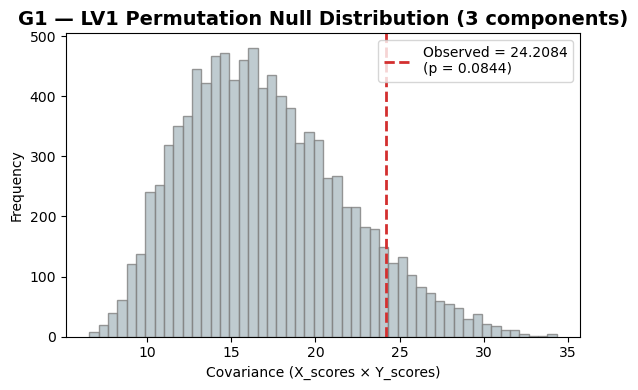

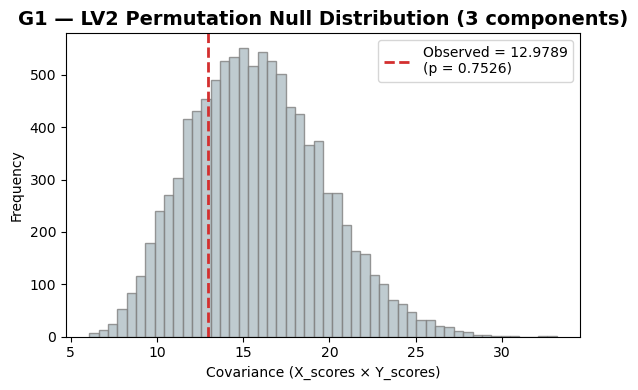

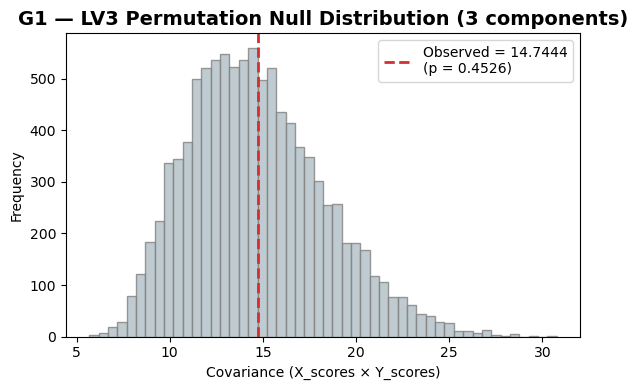

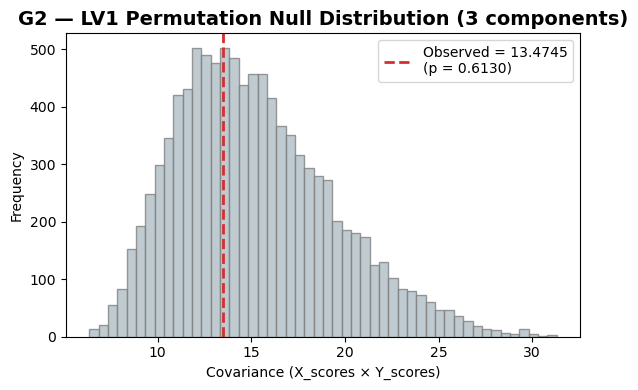

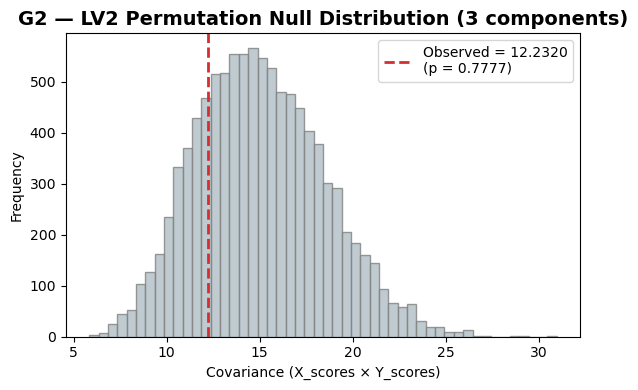

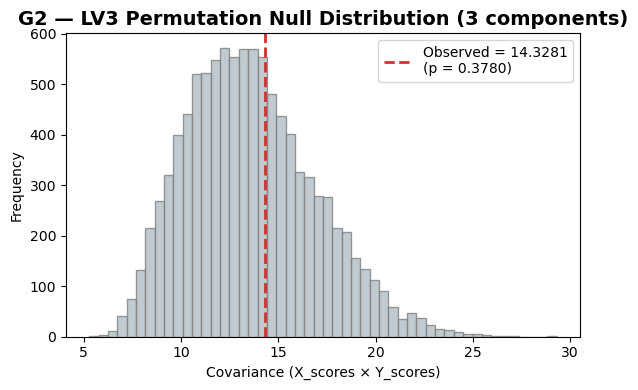

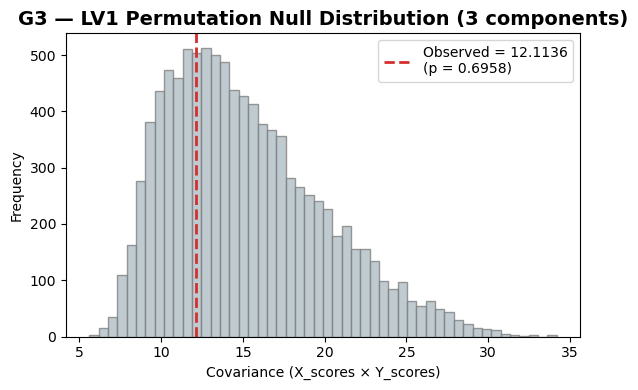

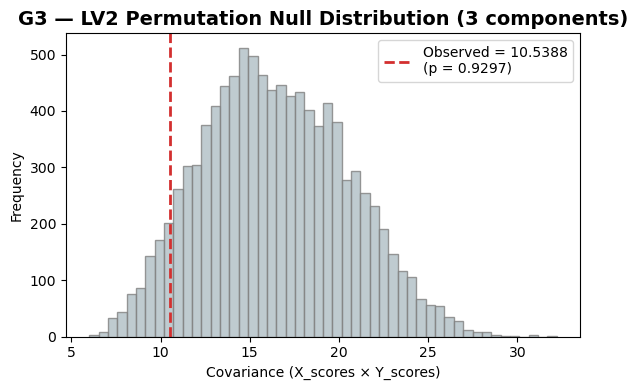

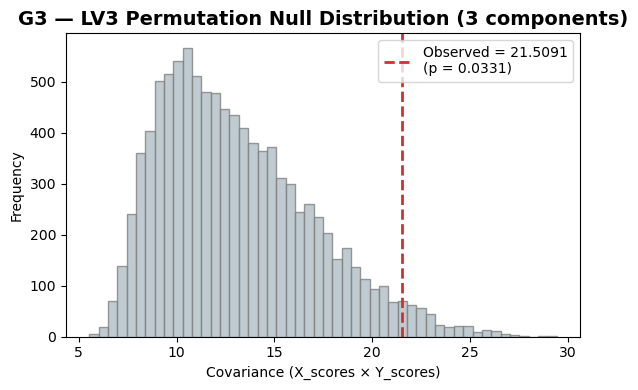

✅ Permutation histograms for 3 components saved to 'new_figures/' and displayed.


In [17]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Create folder for output figures
os.makedirs("new_figures", exist_ok=True)

# Plot permutation null distributions per LV and gradient for 3 components
for grad_name_3comp, res_perm_3comp in results_perm_3comp.items():
    obs_vals_3comp = res_perm_3comp['obs_singular_values']
    perm_vals_3comp = res_perm_3comp['perm_singular_values']
    p_vals_3comp = res_perm_3comp['p_values']
    n_components_3comp = len(obs_vals_3comp)

    for lv_3comp in range(n_components_3comp):
        plt.figure(figsize=(6, 4))
        plt.hist(perm_vals_3comp[:, lv_3comp], bins=50, color="#B0BEC5", edgecolor="gray", alpha=0.8)
        plt.axvline(obs_vals_3comp[lv_3comp], color="#D32F2F", linestyle="--", linewidth=2,
                    label=f"Observed = {obs_vals_3comp[lv_3comp]:.4f}\n(p = {p_vals_3comp[lv_3comp]:.4f})")
        plt.title(f"{grad_name_3comp} — LV{lv_3comp+1} Permutation Null Distribution (3 components)", fontsize=14, fontweight="bold")
        plt.xlabel("Covariance (X_scores × Y_scores)")
        plt.ylabel("Frequency")
        plt.legend()
        plt.tight_layout()
        # Save figure
        plt.savefig(f"new_figures/{grad_name_3comp}_LV{lv_3comp+1}_permutation_hist_3comp.png", dpi=300)
        # Show figure
        plt.show()
        plt.close()

print("✅ Permutation histograms for 3 components saved to 'new_figures/' and displayed.")


## Cross-validation

In [18]:
from sklearn.model_selection import KFold
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr
import numpy as np

# -------------------------------
# Cross-validation parameters
# -------------------------------
n_splits_3comp = 5        # 5-fold CV
n_components_3comp = 3    # now using 3 components
results_cv_3comp = {}

for grad_name_3comp, res_3comp in results_3comp.items():
    print(f"\nCross-validating PLS model for {grad_name_3comp}...")

    X_3comp = res_3comp['X_std']
    Y_3comp = res_3comp['Y_std']
    kf_3comp = KFold(n_splits=n_splits_3comp, shuffle=True, random_state=42)

    corr_list_3comp = np.zeros((n_splits_3comp, n_components_3comp))

    for fold_idx_3comp, (train_idx_3comp, test_idx_3comp) in enumerate(kf_3comp.split(X_3comp)):
        X_train_3comp, X_test_3comp = X_3comp[train_idx_3comp], X_3comp[test_idx_3comp]
        Y_train_3comp, Y_test_3comp = Y_3comp[train_idx_3comp], Y_3comp[test_idx_3comp]

        pls_3comp = PLSRegression(n_components=n_components_3comp)
        pls_3comp.fit(X_train_3comp, Y_train_3comp)

        # Compute test scores
        X_test_scores_3comp = pls_3comp.transform(X_test_3comp)
        Y_pred_3comp = pls_3comp.predict(X_test_3comp)

        # Compute correlation between predicted and actual Y-scores per LV
        for lv_3comp in range(n_components_3comp):
            r_3comp, _ = pearsonr(X_test_scores_3comp[:, lv_3comp],
                                  Y_test_3comp @ pls_3comp.y_weights_[:, lv_3comp])
            corr_list_3comp[fold_idx_3comp, lv_3comp] = r_3comp

    # Average correlations across folds
    mean_corr_3comp = np.nanmean(corr_list_3comp, axis=0)
    std_corr_3comp = np.nanstd(corr_list_3comp, axis=0)

    results_cv_3comp[grad_name_3comp] = {
        'mean_corr_3comp': mean_corr_3comp,
        'std_corr_3comp': std_corr_3comp
    }

    # Print summary
    print(f"{'LV':>3} | {'Mean Corr':>10} | {'SD':>8}")
    print("-" * 28)
    for lv_3comp in range(n_components_3comp):
        sig_marker_3comp = "*" if mean_corr_3comp[lv_3comp] > 0.3 else " "
        print(f"{lv_3comp+1:>3} | {mean_corr_3comp[lv_3comp]:10.3f} | {std_corr_3comp[lv_3comp]:8.3f} {sig_marker_3comp}")

print("\n✅ Cross-validation results stored in `results_cv_3comp`.")



Cross-validating PLS model for G1...
 LV |  Mean Corr |       SD
----------------------------
  1 |      0.156 |    0.215  
  2 |     -0.214 |    0.189  
  3 |      0.025 |    0.158  

Cross-validating PLS model for G2...
 LV |  Mean Corr |       SD
----------------------------
  1 |      0.060 |    0.166  
  2 |     -0.253 |    0.137  
  3 |     -0.033 |    0.153  

Cross-validating PLS model for G3...
 LV |  Mean Corr |       SD
----------------------------
  1 |     -0.196 |    0.165  
  2 |      0.027 |    0.114  
  3 |      0.100 |    0.279  

✅ Cross-validation results stored in `results_cv_3comp`.


## Cross-validation visulization

In [19]:
from sklearn.model_selection import KFold
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr
import numpy as np

# -------------------------------
# Cross-validation parameters
# -------------------------------
n_splits_3comp = 5        # 5-fold CV
n_components_3comp = 3    # now using 3 components
results_cv_3comp = {}

for grad_name_3comp, res_3comp in results_3comp.items():
    print(f"\nCross-validating PLS model for {grad_name_3comp}...")

    X_3comp = res_3comp['X_std']
    Y_3comp = res_3comp['Y_std']
    kf_3comp = KFold(n_splits=n_splits_3comp, shuffle=True, random_state=42)

    corr_list_3comp = np.zeros((n_splits_3comp, n_components_3comp))

    for fold_idx_3comp, (train_idx_3comp, test_idx_3comp) in enumerate(kf_3comp.split(X_3comp)):
        X_train_3comp, X_test_3comp = X_3comp[train_idx_3comp], X_3comp[test_idx_3comp]
        Y_train_3comp, Y_test_3comp = Y_3comp[train_idx_3comp], Y_3comp[test_idx_3comp]

        pls_3comp = PLSRegression(n_components=n_components_3comp)
        pls_3comp.fit(X_train_3comp, Y_train_3comp)

        # Compute test scores
        X_test_scores_3comp = pls_3comp.transform(X_test_3comp)
        Y_pred_3comp = pls_3comp.predict(X_test_3comp)

        # Compute correlation between predicted and actual Y-scores per LV
        for lv_3comp in range(n_components_3comp):
            r_3comp, _ = pearsonr(X_test_scores_3comp[:, lv_3comp],
                                  Y_test_3comp @ pls_3comp.y_weights_[:, lv_3comp])
            corr_list_3comp[fold_idx_3comp, lv_3comp] = r_3comp

    # Average correlations across folds
    mean_corr_3comp = np.nanmean(corr_list_3comp, axis=0)
    std_corr_3comp = np.nanstd(corr_list_3comp, axis=0)

    results_cv_3comp[grad_name_3comp] = {
        'mean_corr_3comp': mean_corr_3comp,
        'std_corr_3comp': std_corr_3comp
    }

    # Print summary
    print(f"{'LV':>3} | {'Mean Corr':>10} | {'SD':>8}")
    print("-" * 28)
    for lv_3comp in range(n_components_3comp):
        sig_marker_3comp = "*" if mean_corr_3comp[lv_3comp] > 0.3 else " "
        print(f"{lv_3comp+1:>3} | {mean_corr_3comp[lv_3comp]:10.3f} | {std_corr_3comp[lv_3comp]:8.3f} {sig_marker_3comp}")

print("\n✅ Cross-validation results stored in `results_cv_3comp`.")



Cross-validating PLS model for G1...
 LV |  Mean Corr |       SD
----------------------------
  1 |      0.156 |    0.215  
  2 |     -0.214 |    0.189  
  3 |      0.025 |    0.158  

Cross-validating PLS model for G2...
 LV |  Mean Corr |       SD
----------------------------
  1 |      0.060 |    0.166  
  2 |     -0.253 |    0.137  
  3 |     -0.033 |    0.153  

Cross-validating PLS model for G3...
 LV |  Mean Corr |       SD
----------------------------
  1 |     -0.196 |    0.165  
  2 |      0.027 |    0.114  
  3 |      0.100 |    0.279  

✅ Cross-validation results stored in `results_cv_3comp`.
